In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import nflDataFunctions as nfldf
import polars as pl
import seaborn as sns
import play_overview as plov
import socket

In [4]:
games, players, plays, pffData = loadData()
week_data = loadWeek()
play_week = get_play_week(games, plays)

In [5]:
passing_plays = plays.filter(pl.col('playType')=='play_type_pass')
plays['playType'].value_counts()

playType,counts
str,u32
"""play_type_pass…",17346
"""play_type_unkn…",633
"""play_type_sack…",1260


In [6]:
play_id = week_data[0]['playId'].unique()[15]
game_id = week_data[0].filter(pl.col('playId')==play_id)['gameId'][0]

play_id

142

73 5


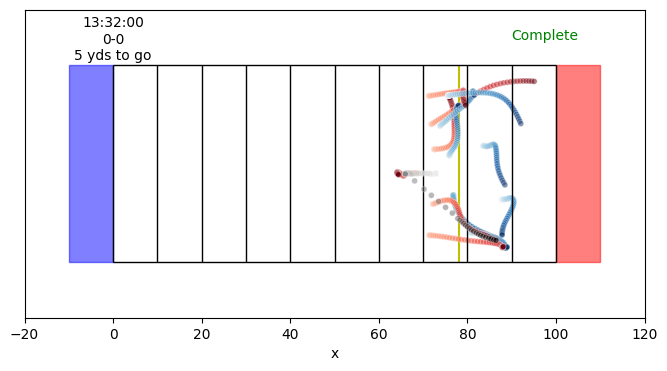

In [8]:
team_color = {'home':{'home':'Reds', 'away':'Blues', 'football':'Greys'}, 
              'away':{'home':'Blues', 'away':'Reds', 'football':'Greys'}}

fig, ax = plov.make_field()

single_play = week_data[0].filter((pl.col('playId')==play_id)
                                  & (pl.col('gameId')==game_id))
game_id = single_play['gameId'][0]
single_play = single_play.with_columns((pl.col('x')-10).alias('x'))

single_play, mirrored = plov.mirror_play(single_play)
offensive_team = single_play.filter(pl.col('position')=='QB')['team'].unique().item()
for player in single_play['nflId'].unique():
    single_trajectory = single_play.filter(pl.col('nflId')==player)
    team = single_trajectory['team'].unique().item()
    palette = team_color[offensive_team][team]
    z_order = single_trajectory['team'].unique().item()=='football'
    sns.scatterplot(data=single_trajectory,
                    x='x',
                    y='y',
                    hue='frameId',
                    palette=palette,
                    zorder=10*z_order,
                    size=1,
                    alpha=0.5,#normalize(single_trajectory['s']),
                    ax=ax,
                   )

play_summary = plays.filter((pl.col('playId')==play_id) 
                            & (pl.col('gameId')==game_id))

plov.next_first_down_line(play_summary, ax, mirror=mirrored)
plov.make_scoreboard(play_summary, ax)
s, color = plov.label_completion(play_summary)
ax.text(x=90, y=60, s=s, color=color)
ax.legend().remove()


In [20]:
def normalize(x):

    return (x-x.min()) / (x.max()-x.min())

In [3]:
def dataPath(year='2021'):
    # function to return path to csv files for particular year of the competition
    hostName = socket.gethostname()
    if 'Andrews-MBP' in hostName:
        return Path(f'/Users/landauland/Documents/SportsScience/nfl-big-data-bowl-{year}')
    elif 'Celia' in hostName:
        return Path(f'/Users/celiaberon/Documents/rec_analysis/NFL/nfl-big-data-bowl-{year}')
    else:
        raise ValueError(f"Did not recognize hostname ({hostName})")

def loadGames(dpath='None'):
    dpath = dataPath() if dpath is None else dpath
    return pl.read_csv(dpath/'games.csv')

def loadPlayers(dpath=None):
    dpath = dataPath() if dpath is None else dpath
    return pl.read_csv(dpath/'players.csv')

def loadPlays(dpath=None):
    dpath = dataPath() if dpath is None else dpath
    return pl.read_csv(dpath/'plays.csv')

def loadPffData(dpath=None):
    dpath = dataPath() if dpath is None else dpath
    if (dpath/'pffScoutingData.csv').exists():
        return pl.read_csv(dpath/'pffScoutingData.csv')
    return None

def loadData(dpath=None):
    return loadGames(dpath), loadPlayers(dpath), loadPlays(dpath), loadPffData(dpath)

def loadWeek(dpath=None):
    return tuple([loadWeekData(week=week) for week in range(1,9)])

def loadWeekData(dpath=None, week=None):
    assert isinstance(week, int), "week must be an integer between 1 and 8!"
    dpath = dataPath() if dpath is None else dpath
    return pl.read_csv(dpath/f'week{week}.csv')
    
def get_play_week(games, plays):
    playWeek = np.zeros(len(plays))
    for game,week in zip(games['gameId'],games['week']):
        idxPlayDuringGame = np.array(plays['gameId']==game, dtype=bool)
        playWeek[idxPlayDuringGame] = week
    return playWeek